# AlphaGPT A-Share Factor Mining & Backtesting Workflow

## 简介 (Introduction)

研究提供了一个完整的、端到端的 AlphaGPT 工作流，涵盖了从数据加载、因子挖掘模型训练、到最终策略回测分析的全过程。

### 核心流程
1.  **配置与初始化**: 设置 Qlib 环境和模型超参数。
2.  **数据加载**: 使用 `QlibDataLoader` 加载沪深300成分股数据。
3.  **核心引擎定义**: 完整的 `AShareAlphaEngine` 类，包含训练循环、奖励计算和 LoRD 正则化。
4.  **模型训练**: 运行 AlphaGPT 进行因子挖掘。
5.  **策略回测**: 完整的 Qlib 回测流程，包含信号清洗、对齐和绩效分析。
6.  **可视化**: 绘制累计收益曲线和风险指标。

In [33]:
import sys
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
from torch.distributions import Categorical

# 抑制警告
warnings.filterwarnings("ignore")

# 确保当前目录在 sys.path 中
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

import qlib
from qlib.data import D
from qlib.constant import REG_CN
from qlib.contrib.evaluate import backtest_daily, risk_analysis
from qlib.contrib.strategy import TopkDropoutStrategy

# 导入项目底层模块
from model_core.config import ModelConfig
from model_core.qlib_loader import QlibDataLoader
from model_core.alphagpt import AlphaGPT, NewtonSchulzLowRankDecay, StableRankMonitor
from model_core.vm import StackVM
from model_core.ashare_backtest import AShareBacktest

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


## 1. 配置与初始化 (Configuration)

在这里我们可以直接修改模型的关键超参数。为了在 Notebook 中快速演示，默认参数已做调整。

In [34]:
# --- Qlib 初始化 ---
provider_uri = os.path.expanduser('~/.qlib/qlib_data/cn_data')
qlib.init(provider_uri=provider_uri, region=REG_CN)
print(f"✅ Qlib initialized with data from: {provider_uri}")

# --- 模型超参数 ---
# 批次大小: 越大越稳定，但显存占用高
ModelConfig.BATCH_SIZE = 256  
# 训练步数: 实际训练建议 1000+
ModelConfig.TRAIN_STEPS = 50  
# 公式最大长度
ModelConfig.MAX_FORMULA_LEN = 20

print(f"⚙️ Config: Batch Size={ModelConfig.BATCH_SIZE}, Steps={ModelConfig.TRAIN_STEPS}")

[35505:MainThread](2026-01-14 21:59:45,048) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[35505:MainThread](2026-01-14 21:59:45,051) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[35505:MainThread](2026-01-14 21:59:45,051) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/shuyan/.qlib/qlib_data/cn_data')}


✅ Qlib initialized with data from: /Users/shuyan/.qlib/qlib_data/cn_data
⚙️ Config: Batch Size=256, Steps=50


## 2. 数据加载与数据集划分 (Data Loading & Splitting)

为了防止模型过拟合（Overfitting）和未来函数（Look-ahead Bias），我们将数据严格划分为三个部分：

1.  **训练集 (Train Set)**: `2021-01-01` ~ `2022-12-31` (2年)。用于训练模型参数，计算梯度。
2.  **验证集 (Valid Set)**: `2023-01-01` ~ `2023-06-30` (0.5年)。用于在训练过程中评估因子表现，选择最佳公式。
3.  **测试集 (Test Set)**: `2023-07-01` ~ `2023-12-31` (0.5年)。完全未见过的数据，仅用于最后的策略回测分析。

In [35]:
# 定义时间段
TRAIN_START = '2021-01-01'
TRAIN_END   = '2022-12-31'
VALID_START = '2023-01-01'
VALID_END   = '2023-06-30'
TEST_START  = '2023-07-01'
TEST_END    = '2023-12-31'

print(f"📅 Data Split:\n  Train: {TRAIN_START} ~ {TRAIN_END}\n  Valid: {VALID_START} ~ {VALID_END}\n  Test : {TEST_START} ~ {TEST_END}")

# 1. 训练集加载器
train_loader = QlibDataLoader()
try:
    print("\n[Loading Train Data]")
    train_loader.load_data(start_time=TRAIN_START, end_time=TRAIN_END, instruments='csi300')
except Exception as e:
    print(f"❌ Train data loading failed: {e}")

# 2. 验证集加载器
valid_loader = QlibDataLoader()
try:
    print("\n[Loading Valid Data]")
    valid_loader.load_data(start_time=VALID_START, end_time=VALID_END, instruments='csi300')
except Exception as e:
    print(f"❌ Valid data loading failed: {e}")

[35505:MainThread](2026-01-14 21:59:45,066) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[35505:MainThread](2026-01-14 21:59:45,069) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[35505:MainThread](2026-01-14 21:59:45,069) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/shuyan/.qlib/qlib_data/cn_data')}


📅 Data Split:
  Train: 2021-01-01 ~ 2022-12-31
  Valid: 2023-01-01 ~ 2023-06-30
  Test : 2023-07-01 ~ 2023-12-31

[Loading Train Data]
Loading A-Share data from Qlib (2021-01-01 to 2022-12-31)...


[35505:MainThread](2026-01-14 21:59:52,347) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[35505:MainThread](2026-01-14 21:59:52,349) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[35505:MainThread](2026-01-14 21:59:52,349) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/shuyan/.qlib/qlib_data/cn_data')}


Computing features...
Data Ready. Feature Shape: torch.Size([393, 6, 485])

[Loading Valid Data]
Loading A-Share data from Qlib (2023-01-01 to 2023-06-30)...
Computing features...
Data Ready. Feature Shape: torch.Size([309, 6, 118])


## 3. 核心引擎定义 (Core Engine)

### 模型架构说明 (Model Architecture)

本 Notebook 使用的 **AlphaGPT** 模型是一个基于 PyTorch 实现的深度强化学习模型，其核心架构是一个 **Decoder-only Transformer** (类似 GPT)，并针对符号回归任务进行了以下关键改进。

#### 1. 核心组件 (Core Components)

该模型在 `model_core/alphagpt.py` 中定义，主要包含以下创新组件：

*   **Looped Transformer (`LoopedTransformerLayer`)**:
    *   **原理**: 采用循环 Transformer 结构，即在一个层内多次循环处理数据 (`num_loops=3`)。
    *   **优势**: 这种递归处理机制（Recurrent Processing）有助于模型在不增加参数量的情况下，进行更深层次的逻辑推理，非常适合生成复杂的数学公式。
    *   **代码对应**: `LoopedTransformerLayer` 类实现了层内的循环调用。

*   **SwiGLU 激活函数 (`SwiGLU`)**:
    *   **原理**: 使用 Swish-Gated Linear Unit 替代传统的 ReLU/GELU。
    *   **优势**: 提供更好的表达能力和梯度传播特性，已被 LLaMA 等大模型证明有效。
    *   **代码对应**: `SwiGLU` 类替代了标准的 `nn.Linear` + `ReLU` 前馈网络。

*   **RMSNorm (`RMSNorm`)**:
    *   **原理**: 使用 Root Mean Square Normalization 替代 LayerNorm。
    *   **优势**: 移除均值中心化操作，计算更高效且在深层网络中训练更稳定。
    *   **代码对应**: `RMSNorm` 类用于 Attention 和 FFN 的前置归一化。

*   **QKNorm (`QKNorm`)**:
    *   **原理**: 对 Attention 中的 Query 和 Key 进行 L2 归一化。
    *   **优势**: 防止训练初期梯度爆炸，提高训练稳定性，特别是在 Transformer 层数较深或循环次数较多时。
    *   **代码对应**: `QKNorm` 类在 Attention 计算前被调用。

*   **MTPHead (`MTPHead`)**:
    *   **原理**: 多任务池化头 (Multi-Task Pooling Head)。
    *   **优势**: 包含多个独立的输出头 (`num_tasks=3`) 和一个路由网络 (`task_router`)。模型可以根据当前上下文动态调整不同任务头的权重，从而更灵活地生成策略分布。
    *   **代码对应**: `MTPHead` 类用于最终的 Logits 生成。

#### 2. 模型整体结构 (Overall Structure)

`AlphaGPT` 类将上述组件组装如下：

1.  **输入嵌入 (Embedding)**:
    *   Token Embedding: 将因子和操作符映射为向量 (`d_model=64`)。
    *   Positional Embedding: 可学习的位置编码。
2.  **骨干网络 (Backbone)**:
    *   `LoopedTransformer`: 堆叠 2 层 `LoopedTransformerLayer`，每层循环 3 次，相当于深度为 6 的逻辑推理深度。
3.  **输出头 (Heads)**:
    *   **Policy Head**: 使用 `MTPHead` 输出动作概率分布 (Logits)。
    *   **Value Head**: 使用 `Linear` 层输出状态价值 (Value)，用于 PPO 训练。

#### 3. 优化与正则化 (Optimization & Regularization)

*   **Low-Rank Decay (LoRD)**: 使用 `NewtonSchulzLowRankDecay` 对 Attention 矩阵进行低秩约束，防止过拟合，提高泛化能力。
*   **Stable Rank Monitor**: 实时监控参数的有效秩，确保模型表达能力。

为了让逻辑完全透明，我们将 `AShareAlphaEngine` 的完整代码定义在此处。这包括了：
 - 模型的初始化
 - 优化器与 LoRD 正则化的配置
 - **核心训练循环 (`train` 方法)**：生成公式 -> 虚拟机执行 -> 计算奖励 -> 反向传播。

In [36]:
class AShareAlphaEngine:
    """
    全功能的 A 股 AlphaGPT 训练引擎
    """
    def __init__(self, train_loader, valid_loader=None, use_lord_regularization=True, lord_decay_rate=1e-3, lord_num_iterations=5):
        # 1. 数据加载器
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        # 2. 初始化模型 (AlphaGPT Transformer)
        self.model = AlphaGPT().to(ModelConfig.DEVICE)
        
        # 标准优化器
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=1e-3)
        
        # 3. LoRD (Low-Rank Decay) 正则化器
        self.use_lord = use_lord_regularization
        if self.use_lord:
            self.lord_opt = NewtonSchulzLowRankDecay(
                self.model.named_parameters(),
                decay_rate=lord_decay_rate,
                num_iterations=lord_num_iterations,
                target_keywords=["q_proj", "k_proj", "attention", "qk_norm"]
            )
            self.rank_monitor = StableRankMonitor(
                self.model,
                target_keywords=["q_proj", "k_proj"]
            )
        else:
            self.lord_opt = None
            self.rank_monitor = None
        
        # 4. 虚拟机与回测计算器
        self.vm = StackVM()
        self.bt = AShareBacktest()
        
        # 5. 状态记录
        self.best_valid_score = -float('inf')
        self.best_formula = None
        self.training_history = {
            'step': [],
            'train_reward': [],
            'valid_score': [],
            'stable_rank': []
        }

    def evaluate_formula(self, formula, loader):
        """Helper to evaluate a single formula on a specific loader"""
        res = self.vm.execute(formula, loader.feat_tensor)
        if res is None: return -5.0 # Syntax Error
        if res.std() < 1e-4: return -2.0 # Constant
        score, _ = self.bt.evaluate(res, loader.raw_data_cache, loader.target_ret)
        return score.item()

    def train(self):
        print("🚀 Starting Alpha Mining...")
        
        pbar = tqdm(range(ModelConfig.TRAIN_STEPS))
        
        for step in pbar:
            bs = ModelConfig.BATCH_SIZE
            inp = torch.zeros((bs, 1), dtype=torch.long, device=ModelConfig.DEVICE)
            
            log_probs = []
            tokens_list = []
            
            # --- 1. 生成公式 (Generate Formulas) ---
            for _ in range(ModelConfig.MAX_FORMULA_LEN):
                logits, _, _ = self.model(inp)
                if torch.isnan(logits).any():
                    logits = torch.nan_to_num(logits, nan=0.0)
                
                dist = Categorical(logits=logits)
                action = dist.sample()
                
                log_probs.append(dist.log_prob(action))
                tokens_list.append(action)
                inp = torch.cat([inp, action.unsqueeze(1)], dim=1)
            
            seqs = torch.stack(tokens_list, dim=1)
            
            # --- 2. 训练集评估 (Evaluate on Train Set) ---
            rewards = torch.zeros(bs, device=ModelConfig.DEVICE)
            
            # Keep track of best formula in this batch to validate
            batch_best_idx = -1
            batch_best_train_score = -float('inf')
            
            for i in range(bs):
                formula = seqs[i].tolist()
                score = self.evaluate_formula(formula, self.train_loader)
                rewards[i] = score
                
                if score > -2.0 and score > batch_best_train_score:
                    batch_best_train_score = score
                    batch_best_idx = i
            
            # --- 3. 验证集评估 (Validation) ---
            # 仅验证本 Batch 中表现最好的公式，以节省计算资源
            current_valid_score = -999
            if self.valid_loader and batch_best_idx >= 0:
                best_formula_in_batch = seqs[batch_best_idx].tolist()
                current_valid_score = self.evaluate_formula(best_formula_in_batch, self.valid_loader)
                
                # Update Global Best based on VALIDATION score
                if current_valid_score > -2.0 and current_valid_score > self.best_valid_score:
                    self.best_valid_score = current_valid_score
                    self.best_formula = best_formula_in_batch
            
            # --- 4. 策略梯度更新 (Policy Gradient Update) ---
            adv = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
            loss = 0
            for t in range(len(log_probs)):
                loss += -log_probs[t] * adv
            loss = loss.mean()
            
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            
            if self.use_lord:
                self.lord_opt.step()
            
            # --- 5. Logging ---
            avg_reward = rewards.mean().item()
            postfix_dict = {'TrainRew': f"{avg_reward:.3f}", 'ValidBest': f"{self.best_valid_score:.3f}"}
            
            if self.use_lord and step % 10 == 0:
                stable_rank = self.rank_monitor.compute()
                postfix_dict['Rank'] = f"{stable_rank:.2f}"
                self.training_history['stable_rank'].append(stable_rank)
            
            self.training_history['step'].append(step)
            self.training_history['train_reward'].append(avg_reward)
            self.training_history['valid_score'].append(current_valid_score)
            
            pbar.set_postfix(postfix_dict)
        
        print(f"\n✅ Training Completed. Best Valid Score: {self.best_valid_score:.4f}")

## 4. 运行训练 (Execution)

初始化引擎并开始训练。

In [37]:
engine = AShareAlphaEngine(train_loader, valid_loader, use_lord_regularization=True)
engine.train()

🚀 Starting Alpha Mining...


  0%|          | 0/50 [00:00<?, ?it/s]


✅ Training Completed. Best Valid Score: 1.0326


In [38]:
# 展示最佳公式
best_formula = engine.best_formula

# 自动保存最佳策略
if best_formula:
    os.makedirs("outputs", exist_ok=True)
    with open("outputs/best_ashare_strategy.json", "w") as f:
        json.dump(best_formula, f)
    print("✅ Strategy saved to outputs/best_ashare_strategy.json")
    
    # 保存模型权重
    torch.save(engine.model.state_dict(), "outputs/alphagpt_model.pth")
    print("✅ Model weights saved to outputs/alphagpt_model.pth")

if best_formula is None and os.path.exists("outputs/best_ashare_strategy.json"):
    with open("outputs/best_ashare_strategy.json", "r") as f:
        best_formula = json.load(f)
    print("Loaded strategy from file.")

print(f"🏆 Best Formula Tokens: {best_formula}")

✅ Strategy saved to outputs/best_ashare_strategy.json
✅ Model weights saved to outputs/alphagpt_model.pth
🏆 Best Formula Tokens: [0, 0, 2, 2, 9, 3, 12, 8, 14, 14, 15, 6, 16, 9, 11, 14, 3, 4, 10, 13]


## 5. 策略回测 (Test Set Backtest)

我们使用 **测试集 (2023-07 ~ 2023-12)** 进行最终的样本外回测。这是模型从未见过的数据，能真实反映策略的泛化能力。

以下是完整的回测逻辑，包含：
1.  **数据对齐**: 处理 MultiIndex 对齐问题。
2.  **数据过滤**: 剔除停牌和无数据股票，防止 Qlib 报错。
3.  **回测执行**: 调用 `backtest_daily`。

In [39]:
def run_full_backtest(formula, start_time, end_time):
    if not formula:
        print("❌ No formula to backtest.")
        return
        
    print(f"🚀 Preparing Backtest ({start_time} ~ {end_time})...")
    
    # 1. 加载回测数据
    bt_loader = QlibDataLoader()
    bt_loader.load_data(start_time=start_time, end_time=end_time, instruments='csi300')
    
    # 2. 计算因子值
    vm = StackVM()
    factor_scores = vm.execute(formula, bt_loader.feat_tensor)
    
    if factor_scores is None:
        print("❌ Error computing factors. The formula might be invalid or produce constant values.")
        print(f"Formula: {formula}")
        return

    # 3. 转换为 Qlib 格式
    # 获取原始 DataFrame 结构
    instruments = D.instruments(market='csi300')
    raw_df = D.features(instruments, ['$close'], start_time=start_time, end_time=end_time)
    
    if raw_df.index.names == ['instrument', 'datetime']:
        unstacked = raw_df['$close'].unstack(level='datetime')
    else:
        unstacked = raw_df['$close'].unstack(level='instrument').T
        
    asset_list = unstacked.index
    time_list = pd.to_datetime(unstacked.columns)
    
    scores_t = factor_scores.T.cpu().numpy()
    score_df = pd.DataFrame(scores_t, index=time_list, columns=asset_list)
    
    # Stack & Align
    pred_df = score_df.stack().to_frame('score')
    pred_df.index.names = ['datetime', 'instrument']
    
    if raw_df.index.names == ['instrument', 'datetime']:
        raw_df_aligned = raw_df.swaplevel().sort_index()
    else:
        raw_df_aligned = raw_df.sort_index()
        
    # 4. 数据清洗 (关键步骤)
    merged_df = pred_df.join(raw_df_aligned['$close'], how='inner')
    valid_mask = ~merged_df['$close'].isna()
    pred_df = merged_df.loc[valid_mask, ['score']].sort_index()
    
    print(f"✅ Signal Ready. Shape: {pred_df.shape}")
    
    # 5. 运行 Qlib 回测
    strategy_config = {
        "topk": 30,
        "n_drop": 30,
        "signal": pred_df,
    }
    
    report_normal, positions_normal = backtest_daily(
        start_time=start_time, 
        end_time=end_time, 
        strategy=TopkDropoutStrategy(**strategy_config),
        account=1000000,
        benchmark='SH000300',
    )
    
    return report_normal

# 运行回测 (使用 Test Set)
report = run_full_backtest(best_formula, start_time=TEST_START, end_time=TEST_END)

[35505:MainThread](2026-01-14 22:00:39,991) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[35505:MainThread](2026-01-14 22:00:39,996) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[35505:MainThread](2026-01-14 22:00:39,996) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/shuyan/.qlib/qlib_data/cn_data')}


🚀 Preparing Backtest (2023-07-01 ~ 2023-12-31)...
Loading A-Share data from Qlib (2023-07-01 to 2023-12-31)...
Computing features...
Data Ready. Feature Shape: torch.Size([314, 6, 124])


[35505:MainThread](2026-01-14 22:00:54,676) WARNING - qlib.BaseExecutor - [executor.py:121] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x376ae44d0>
[35505:MainThread](2026-01-14 22:00:54,685) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange


✅ Signal Ready. Shape: (37200, 1)


[35505:MainThread](2026-01-14 22:01:03,678) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[35505:MainThread](2026-01-14 22:01:03,679) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.


backtest loop:   0%|          | 0/124 [00:00<?, ?it/s]

## 6. 结果可视化 (Visualization)

展示策略的累计收益、超额收益以及风险指标。

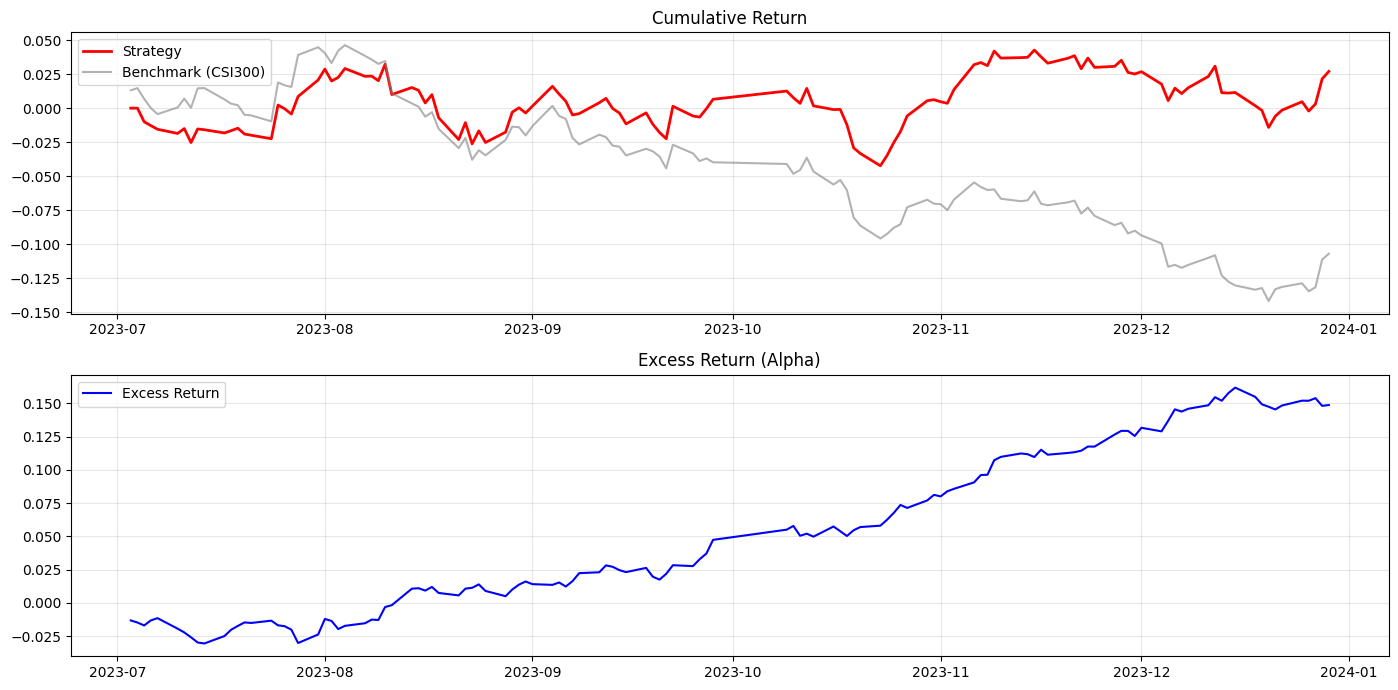


--- Performance Metrics ---
                       risk
mean               0.001129
std                0.004344
annualized_return  0.268673
information_ratio  4.009107
max_drawdown      -0.019400


In [40]:
if 'report' in locals() and report is not None:
    # 计算指标
    report['excess_return'] = report['return'] - report['bench']
    report['cumulative_return'] = (1 + report['return']).cumprod() - 1
    report['cumulative_bench'] = (1 + report['bench']).cumprod() - 1
    report['cumulative_excess'] = (1 + report['excess_return']).cumprod() - 1

    # 绘图
    plt.figure(figsize=(14, 7))
    
    plt.subplot(2, 1, 1)
    plt.plot(report.index, report['cumulative_return'], label='Strategy', color='red', linewidth=2)
    plt.plot(report.index, report['cumulative_bench'], label='Benchmark (CSI300)', color='grey', alpha=0.6)
    plt.title('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(report.index, report['cumulative_excess'], label='Excess Return', color='blue')
    plt.title('Excess Return (Alpha)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印风险分析
    print("\n--- Performance Metrics ---")
    analysis = risk_analysis(report['excess_return'])
    print(analysis)
else:
    print("No report data generated.")